</center> Clbesch_FlowField</center>

# 数据

## 读取原始数据

In [1]:
import scipy.io as sio
import torch

# 读取速度场数据
velocity_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/velocity_field.mat')
ux0 = torch.tensor(velocity_data['ux'], dtype=torch.float32)
uy0 = torch.tensor(velocity_data['uy'], dtype=torch.float32)

# 读取波函数数据
wave_function_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/wave_function.mat')
psi1_0 = torch.tensor(wave_function_data['psi1'], dtype=torch.complex64)
psi2_0 = torch.tensor(wave_function_data['psi2'], dtype=torch.complex64)

# 读取误差场数据
error_field_data = sio.loadmat('D:/zjPhD/Programzj/psiToU/Ginzburg_Lan/Clebsch_flowfield/data/High_Resolution/train/error_field.mat')
vx_error0 = torch.tensor(error_field_data['vx_error'], dtype=torch.float32)
vy_error0 = torch.tensor(error_field_data['vy_error'], dtype=torch.float32)

# 打印数据形状以确认
print(f'ux shape: {ux0.shape}')
print(f'uy shape: {uy0.shape}')
print(f'psi1 shape: {psi1_0.shape}')
print(f'psi2 shape: {psi2_0.shape}')
print(f'vx_error shape: {vx_error0.shape}')
print(f'vy_error shape: {vy_error0.shape}')


ux shape: torch.Size([512, 512])
uy shape: torch.Size([512, 512])
psi1 shape: torch.Size([512, 512])
psi2 shape: torch.Size([512, 512])
vx_error shape: torch.Size([512, 512])
vy_error shape: torch.Size([512, 512])


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


# 常用函数


In [3]:
# 归一化函数
def normalize(tensor):
    return (tensor - tensor.mean()) / tensor.std()


# 模型

## 预测误差

In [4]:
import torch 
import torch.nn as nn


In [5]:
class ErrorPredictCNN(nn.Module):
    def __init__(self):
        super(ErrorPredictCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()  

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()


    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.conv4(x)

        return x

In [6]:
model  = ErrorPredictCNN().to(device)

In [7]:
ux = ux0.clone()
uy = uy0.clone()
psi1 = psi1_0.clone()
psi2 = psi2_0.clone()

psi1_real  = torch.real(psi1)
psi1_imag  = torch.imag(psi1)
psi2_real  = torch.real(psi2)
psi2_imag  = torch.imag(psi2)


vx_error = vx_error0.clone()
vy_error = vy_error0.clone()



print(f'ux shape: {ux.shape}')
print(f'uy shape: {uy.shape}')
print(f'psi1 shape: {psi1.shape}')
print(f'psi2 shape: {psi2.shape}')
print(f'psi1_real shape: {psi1_real.shape}')
print(f'psi1_imag shape: {psi1_imag.shape}')
print(f'psi2_real shape: {psi2_real.shape}')
print(f'psi2_imag shape: {psi2_imag.shape}')

print(f'vx_error shape: {vx_error.shape}')
print(f'vy_error shape: {vy_error.shape}')



ux shape: torch.Size([512, 512])
uy shape: torch.Size([512, 512])
psi1 shape: torch.Size([512, 512])
psi2 shape: torch.Size([512, 512])
psi1_real shape: torch.Size([512, 512])
psi1_imag shape: torch.Size([512, 512])
psi2_real shape: torch.Size([512, 512])
psi2_imag shape: torch.Size([512, 512])
vx_error shape: torch.Size([512, 512])
vy_error shape: torch.Size([512, 512])


In [8]:
# 读取和归一化数据
ux = normalize(ux0.clone().unsqueeze(0).unsqueeze(0)).to(device)
uy = normalize(uy0.clone().unsqueeze(0).unsqueeze(0)).to(device)
psi1 = psi1_0.clone().unsqueeze(0).unsqueeze(0).to(device)
psi2 = psi2_0.clone().unsqueeze(0).unsqueeze(0).to(device)

# 将复数数据拆分为实部和虚部，并进行归一化
psi1_real = normalize(torch.real(psi1)).to(device)
psi1_imag = normalize(torch.imag(psi1)).to(device)
psi2_real = normalize(torch.real(psi2)).to(device)
psi2_imag = normalize(torch.imag(psi2)).to(device)

# 错误数据不需要归一化，因为它们是训练目标
vx_error = vx_error0.clone().unsqueeze(0).unsqueeze(0).to(device)
vy_error = vy_error0.clone().unsqueeze(0).unsqueeze(0).to(device)

# 打印数据形状
print(f'ux shape: {ux.shape}')
print(f'uy shape: {uy.shape}')
print(f'psi1_real shape: {psi1_real.shape}')
print(f'psi1_imag shape: {psi1_imag.shape}')
print(f'psi2_real shape: {psi2_real.shape}')
print(f'psi2_imag shape: {psi2_imag.shape}')

print(f'vx_error shape: {vx_error.shape}')
print(f'vy_error shape: {vy_error.shape}')

ux shape: torch.Size([1, 1, 512, 512])
uy shape: torch.Size([1, 1, 512, 512])
psi1_real shape: torch.Size([1, 1, 512, 512])
psi1_imag shape: torch.Size([1, 1, 512, 512])
psi2_real shape: torch.Size([1, 1, 512, 512])
psi2_imag shape: torch.Size([1, 1, 512, 512])
vx_error shape: torch.Size([1, 1, 512, 512])
vy_error shape: torch.Size([1, 1, 512, 512])


In [9]:
input_data = torch.cat((ux, uy, psi1_real, psi1_imag, psi2_real, psi2_imag), dim=1)

input_data.shape

torch.Size([1, 6, 512, 512])

In [10]:
# 目标输出合并为2个通道
target_error = torch.cat((vx_error, vy_error), dim=1)

print(f'target_error shape: {target_error.shape}')

target_error shape: torch.Size([1, 2, 512, 512])


In [11]:
# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
# 训练循环
num_epochs = 100000  # 设定你想要的训练轮数
for epoch in range(num_epochs):
    # 清零梯度
    optimizer.zero_grad()
    
    # 前向传播
    predicted_error = model(input_data)
    
    # 计算损失
    loss = 100000*criterion(predicted_error, target_error)
    
    # 反向传播
    loss.backward()
    
    # 更新参数
    optimizer.step()
    
    # 打印每个 epoch 的损失
    if (epoch + 1) % 10 == 0:  # 每10个 epoch 打印一次
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/100000], Loss: 6.5893
Epoch [20/100000], Loss: 1.4344
Epoch [30/100000], Loss: 1.0710
Epoch [40/100000], Loss: 0.7649
Epoch [50/100000], Loss: 0.5174
Epoch [60/100000], Loss: 0.3895
Epoch [70/100000], Loss: 0.3292
Epoch [80/100000], Loss: 0.3004
Epoch [90/100000], Loss: 0.2804
Epoch [100/100000], Loss: 0.2647
Epoch [110/100000], Loss: 0.2500
Epoch [120/100000], Loss: 0.2351
Epoch [130/100000], Loss: 0.2227
Epoch [140/100000], Loss: 0.2118
Epoch [150/100000], Loss: 0.2024
Epoch [160/100000], Loss: 0.1937
Epoch [170/100000], Loss: 0.1851
Epoch [180/100000], Loss: 0.1762
Epoch [190/100000], Loss: 0.1671
Epoch [200/100000], Loss: 0.1587
Epoch [210/100000], Loss: 0.1502
Epoch [220/100000], Loss: 0.1418
Epoch [230/100000], Loss: 0.1338
Epoch [240/100000], Loss: 0.1268
Epoch [250/100000], Loss: 0.1206
Epoch [260/100000], Loss: 0.1153
Epoch [270/100000], Loss: 0.1104
Epoch [280/100000], Loss: 0.1056
Epoch [290/100000], Loss: 0.1013
Epoch [300/100000], Loss: 0.0975
Epoch [310/100000],

In [13]:
# 可视化结果（在 GPU 上训练，但绘图在 CPU 上）
predicted_error_cpu = predicted_error.detach().cpu().numpy()
vx_error_cpu = vx_error.detach().cpu().numpy()



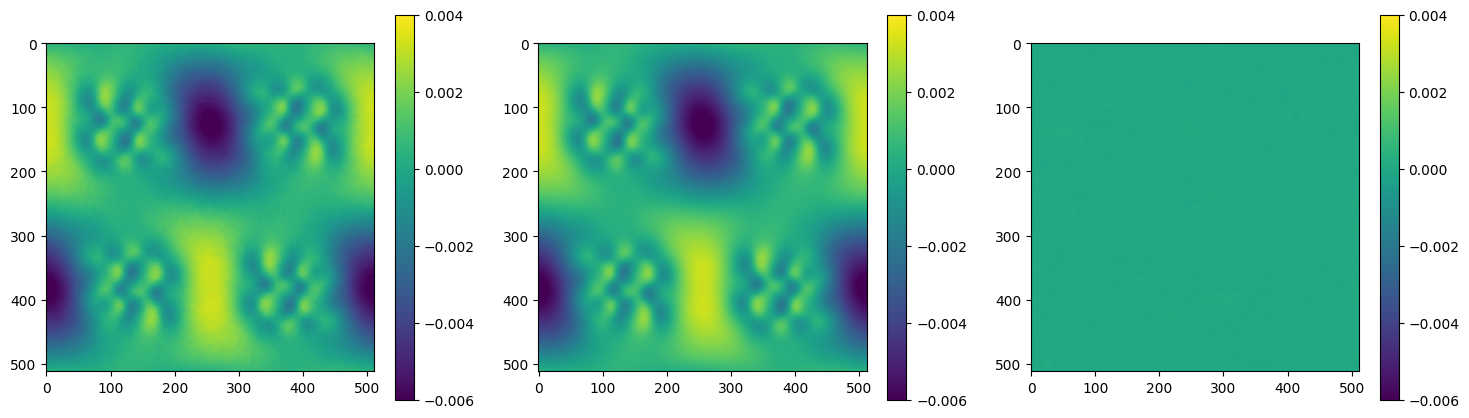

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.imshow(predicted_error_cpu[0,0,:,:],vmin=-0.006,vmax=0.004)
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(vx_error_cpu[0,0,:,:],vmin=-0.006,vmax=0.004)
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(predicted_error_cpu[0,0,:,:] - vx_error_cpu[0,0,:,:],vmin=-0.006,vmax=0.004)
plt.colorbar()

plt.show()